# Análisis de Series Temporales - Trabajo Práctico 2

Integrantes:
* Bermejo, Joaquín
* Scarafía, Franco
* Seward, Gerardrard

## 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from neuralprophet import NeuralProphet
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe


from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

/home/ge/.venv/general312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


## 2. Carga de datasets

In [2]:
df = pd.read_csv('input/viajes_bici.csv')

df['fecha'] = pd.to_datetime(df['fecha'])

df = df[(df['destino'] == 'Fac. Ciencias Económicas') | (df['destino'] == 'Fac. Medicina') | (df['destino'] == 'Fac. de Ingeniería')]

df_train = df[df['fecha'] < '2024-01-01']
df_test  = df[df['fecha'] >= '2024-01-01']

In [3]:
df_train = TimeSeriesDataFrame(df_train, id_column='destino',timestamp_column='fecha')

In [4]:
df_train

viajes
item_id                  timestamp         
Fac. Ciencias Económicas 2021-01-01      26
Fac. Medicina            2021-01-01      29
Fac. de Ingeniería       2021-01-01      42
Fac. Ciencias Económicas 2021-01-02      42
Fac. Medicina            2021-01-02      34
...                                     ...
                         2023-12-30      35
Fac. de Ingeniería       2023-12-30      54
Fac. Ciencias Económicas 2023-12-31      35
Fac. Medicina            2023-12-31      41
Fac. de Ingeniería       2023-12-31      29

[3285 rows x 1 columns]

In [5]:
predictor = TimeSeriesPredictor(
    prediction_length=120,
    path="autoGL_models",
    target="viajes",
    eval_metric="RMSE",
)

predictor.fit(
    df_train,
    presets="best_quality", #"fast_training", "high_quality" , "medium_quality" "best_quality"
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/ge/MCD/Series/tp-series-temporales/autoGL_models'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat, 08 Feb 2025 18:54:55 +0000
CPU Count:          12
GPU Count:          1
Memory Avail:       10.21 GB / 15.54 GB (65.7%)
Disk Space Avail:   764.92 GB / 907.45 GB (84.3%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 120,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'viajes',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provi

In [6]:
df_test = TimeSeriesDataFrame(df_test, id_column='destino',timestamp_column='fecha')

predictions = predictor.predict(df_train)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [7]:
predictor.leaderboard(df_test)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TiDE,-32.928097,-19.889152,0.101701,0.032450,122.782067,12
1,DeepAR,-34.840886,-21.477623,0.493214,0.476544,81.886587,10
2,PatchTST,-35.932440,-23.530168,0.051403,0.025320,34.911184,11
3,WeightedEnsemble,-38.522263,-17.024335,1.086690,1.733845,2.427339,13
4,DirectTabular,-42.051001,-35.933749,0.090575,0.102005,2.340688,3
5,TemporalFusionTransformer,-42.100705,-24.737861,0.080217,0.026006,88.235009,9
6,ChronosFineTuned[bolt_small],-42.106805,-19.112718,0.372954,0.050582,82.412573,8
7,SeasonalNaive,-42.106809,-28.755636,1.125328,1.201407,1.828581,1
8,RecursiveTabular,-42.106809,-31.980344,0.034641,1.148262,3.109007,2
9,NPTS,-42.106809,-33.093540,0.073178,0.819576,0.685001,4


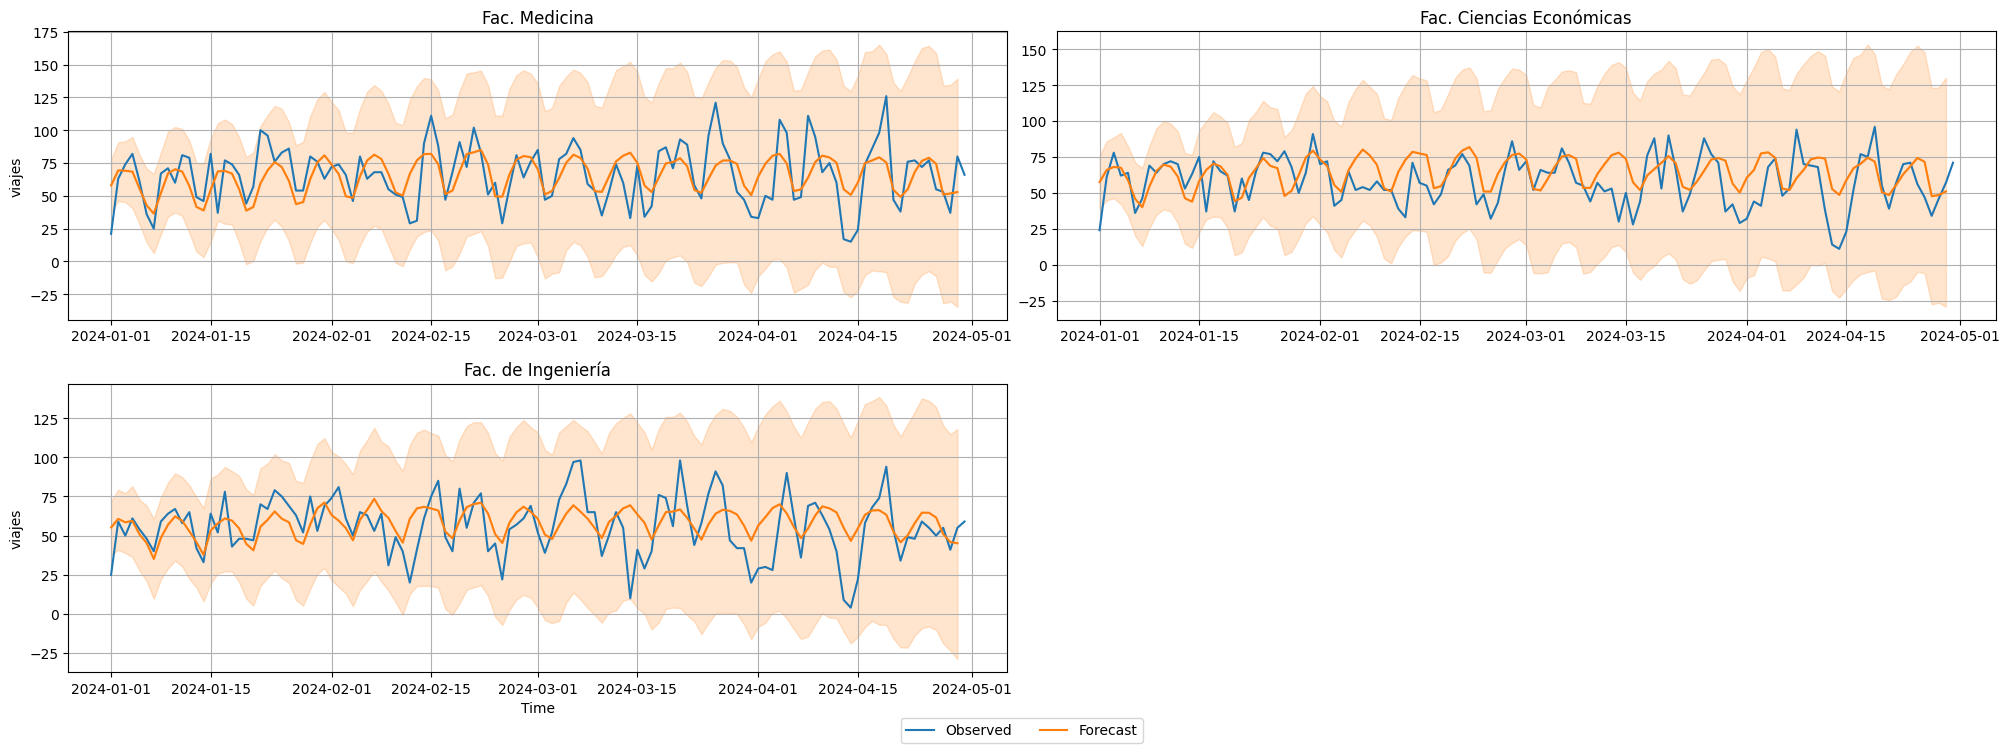

In [9]:
predictor.plot(df_test, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)